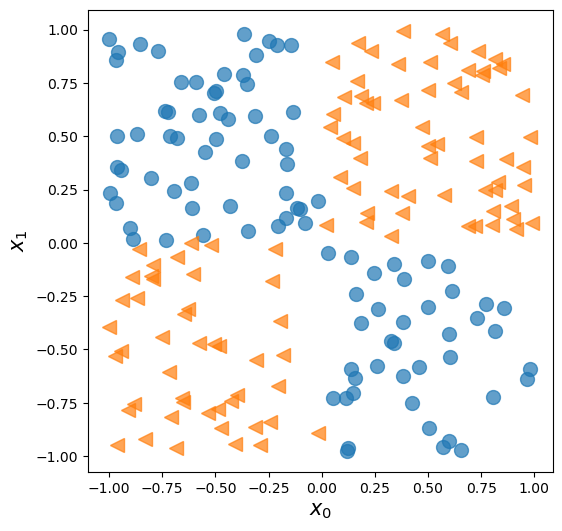

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

#set seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)

#generate dataset
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0

#plot training examples
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.7, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.7, markersize=10)
plt.xlabel(r'$x_0$', size=15)
plt.ylabel(r'$x_1$', size=15)
plt.show()

We will use half of the training set ($100$ examples) for training, and the remaining half for validation.

In [2]:
#split dataset into training and validation
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

Next, we will create a `DataLoader` object for the train data that uses a batch size of $2$.

In [3]:
from torch.utils.data import DataLoader, TensorDataset

#create TensorDataset object
train_ds = TensorDataset(x_train, y_train)

#create DataLoader object from the dataset object
batch_size = 2
torch.manual_seed(1) #set seed for reproducibility
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

We will build a neural network using the `nn.Module` class. In this approach, we create a class which inherits from `nn.Module` and define the method `__init__()` as a constructor. In this method, we define the layers as attributes of the class so they can be accessed by the `self` reference attribute. Then, in the `forward()` method, we specify how to use these layers in the forward pass of the NN.

In [4]:
#define class inheriting from nn.Module
class MultiLayerNN(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

Observe that we put all the layers in an `nn.ModuleList` object (which is just a `list` object composed of the `nn.Module` items) that we can reference in the other methods of the class.

Now, we define an instance of this class to be our model and train the model using the same `train` function from before.

In [50]:
#define model as instance of MultiLayerNN
model = MultiLayerNN()
model

MultiLayerNN(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [51]:
#define binary cross-entropy loss function
loss_fn = nn.BCELoss()

#define SGD optimizer using model parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.007)

#define function to train the model
def train(model, num_epochs, train_dl, x_valid, y_valid):
    #set up outputs of function (return training loss and accuracy and validation loss and accuracy)
    loss_hist_train = [0] * num_epochs
    acc_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    acc_hist_valid = [0] * num_epochs
    
    #implement training loop
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            #generate predictions
            pred = model(x_batch)[:, 0]
            
            #calculate loss
            loss = loss_fn(pred, y_batch)
            
            #compute gradients
            loss.backward()
            
            #update parameters using gradients
            optimizer.step()
            
            #reset the gradients to zero
            optimizer.zero_grad()
            
            #add up the training loss and accuracy for each batch
            loss_hist_train[epoch] += loss.item()
            is_acc = ((pred>=0.5).float() == y_batch).float()
            acc_hist_train[epoch] += is_acc.mean()
        
        #calculate training loss and accuracy over the epoch
        loss_hist_train[epoch] /= (n_train/batch_size)
        acc_hist_train[epoch] /= (n_train/batch_size)
        
        #use the newly trained model to predict the validation set
        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_acc = ((pred>=0.5).float() == y_valid).float()
        acc_hist_valid[epoch] = is_acc.mean()
        
    return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid

In [52]:
#train our model
torch.manual_seed(1)
num_epochs = 500
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Now, we will use the `plot_decision_regions` function from the `mlxtend` library to visualize the decision regions derived by the multilayer NN model above while simultaneously plotting the learning curves for binary cross-entropy loss and classification accuracy on both the training and validation sets.

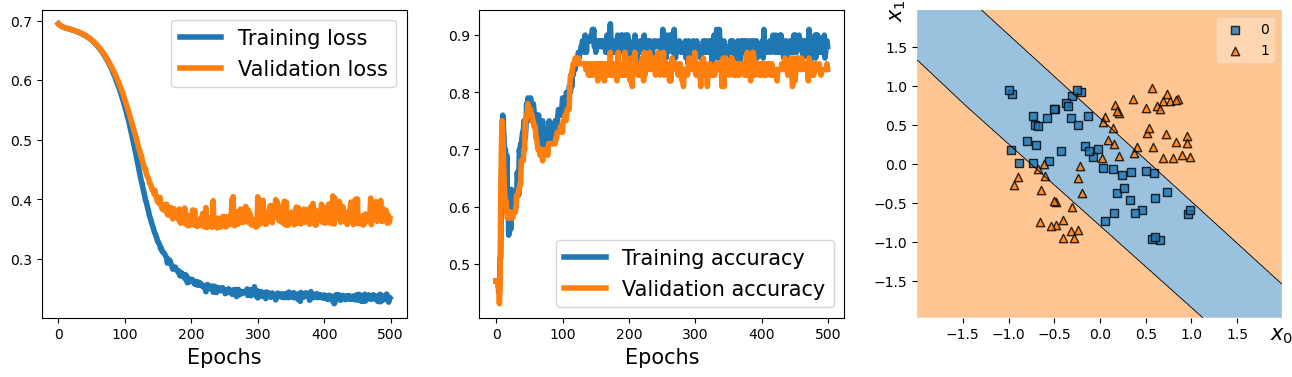

In [53]:
from mlxtend.plotting import plot_decision_regions

#set up figures
fig = plt.figure(figsize=(16, 4))

#plot BCE loss learning curves (training and validation) on same set of axes
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Training loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plot classification accuracy learning curves (training and validation) on same set of axes
ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plot decision regions
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64), 
                      clf=model)
ax.set_xlabel(r'$x_0$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_1$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#display plot
plt.show()

# Writing custom layers in nn.Module

If we want to define a new layer that is not natively supported by PyTorch, we can define a new class inheriting the `nn.Module` class. For this new class, we have to define both the constructor `__init__()` method in which we define the variables and other tensors required for the customized layer. We can also initialize these variables and tensors if the `input_size` is given to the constructor.

To consider a practical example, we will implement a custom layer called `NoisyLinear` that computes $\mathbf{w}(\mathbf{x}+\epsilon) + b$, where $\epsilon$ represents a random noise variable sampled from a Gaussian distribution. To learn more about why it is beneficial to do this, see Chris Bishop, Training with Noise
is Equivalent to Tikhonov Regularization, 1994, available at <https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/bishop-tikhonov-nc-95.pdf>.

In [9]:
#define NoisyLinear layer
class NoisyLinear(nn.Module):
    
    #constructor
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        
        #define and initialize weight tensor
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w) #nn.Parameter is a Tensor that is a module parameter
        nn.init.xavier_uniform_(self.w)
        
        #define and initialize bias vector
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        
        #read in standard deviation of noise variable
        self.noise_stddev = noise_stddev
    
    #define operation for forward pass
    def forward(self, x, training=False):
        
        #if training, add epsilon (noise) to input tensor
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
            
        #for inference or evaluation, do not add noise
        else:
            x_new = x
        
        #return weight * x_new + bias
        return torch.add(torch.mm(x_new, self.w), self.b)

Note that in the `forward()` method, we include the argument `training=False` to distinguish the operation of the layer during training from its operation when used in the context of inference or evaluation.

Let's test out the `NoisyLinear` layer to see how it functions when applied to a vector of zeros.

In [13]:
#create vector of zeros
t = torch.zeros((1, 4))

#create instance of NoisyLinear and apply it to the vector of zeros
torch.manual_seed(1)
nl = NoisyLinear(4, 2)
print(nl(t, training=True)) #set training=True
print(nl(t))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


Observe that when `training=True`, the `NoisyLinear` layer adds noise to the input vector, but by default it only returns a vector of zeros with specified length $2$.

Now, we will create a multilayer NN class `NoisyMultiLayerNN` which inherits from the `nn.Module` class and includes a `NoisyLinear` layer.

In [58]:
#create subclass of nn.Module with NoisyLinear layer
class NoisyMultiLayerNN(nn.Module):
    
    '''
    Define the layers:
        1. NoisyLinear
            - input size: 2
            - output size: 4
            - activation: ReLU
        2. Linear
            - input size: 4
            - output size: 4
            - activation: ReLU
        3. Linear
            - input size: 4
            - output size: 1
            - activation: Sigmoid
    '''
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.01)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
    
    #define forward pass
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

Now, we will define the training loop for the model similarly to how we did previously. However, this time we set `pred = model(x_batch, True)[:, 0]` when computing the forward pass of the neural network on the training batches.

In [59]:
#create instance of model
noisy_model = NoisyMultiLayerNN()

#define binary cross-entropy loss function
loss_fn = nn.BCELoss()

#define SGD optimizer using model parameters
optimizer = torch.optim.SGD(noisy_model.parameters(), lr=0.007)

#define function to train the model
def train(model, num_epochs, train_dl, x_valid, y_valid):
    #set up outputs of function (return training loss and accuracy and validation loss and accuracy)
    loss_hist_train = [0] * num_epochs
    acc_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    acc_hist_valid = [0] * num_epochs
    
    #implement training loop
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            #generate predictions
            pred = model(x_batch, True)[:, 0]
            
            #calculate loss
            loss = loss_fn(pred, y_batch)
            
            #compute gradients
            loss.backward()
            
            #update parameters using gradients
            optimizer.step()
            
            #reset the gradients to zero
            optimizer.zero_grad()
            
            #add up the training loss and accuracy for each batch
            loss_hist_train[epoch] += loss.item()
            is_acc = ((pred>=0.5).float() == y_batch).float()
            acc_hist_train[epoch] += is_acc.mean()
        
        #calculate training loss and accuracy over the epoch
        loss_hist_train[epoch] /= (n_train/batch_size)
        acc_hist_train[epoch] /= (n_train/batch_size)
        
        #use the newly trained model to predict the validation set
        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_acc = ((pred>=0.5).float() == y_valid).float()
        acc_hist_valid[epoch] = is_acc.mean()
        
    return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid

We train the model for $500$ epochs, then we plot the learning curves and the decision boundary derived by the model.

In [60]:
#train our model
torch.manual_seed(1)
num_epochs = 500
history_n = train(noisy_model, num_epochs, train_dl, x_valid, y_valid)

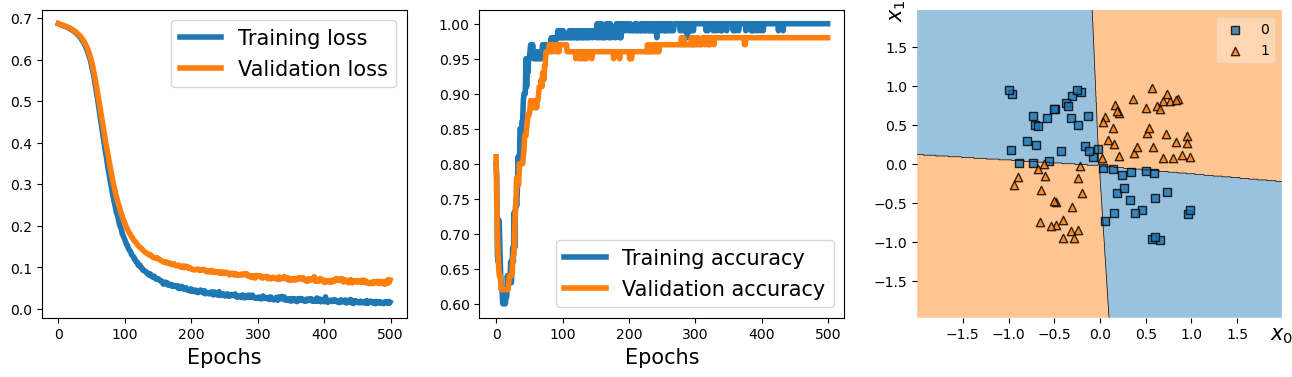

In [61]:
from mlxtend.plotting import plot_decision_regions

#set up figures
fig = plt.figure(figsize=(16, 4))

#plot BCE loss learning curves (training and validation) on same set of axes
ax = fig.add_subplot(1, 3, 1)
plt.plot(history_n[0], lw=4)
plt.plot(history_n[1], lw=4)
plt.legend(['Training loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plot classification accuracy learning curves (training and validation) on same set of axes
ax = fig.add_subplot(1, 3, 2)
plt.plot(history_n[2], lw=4)
plt.plot(history_n[3], lw=4)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plot decision regions
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64), 
                      clf=noisy_model)
ax.set_xlabel(r'$x_0$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_1$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#display plot
plt.show()

We observe significantly better performance from the model that includes the noisy layer. Unsurprisingly, the decision boundaries derived by the model are also very close to the correct decision boundaries. Below, we see how our model performs on a test set.

In [65]:
#set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

#generate test set
x_test = np.random.uniform(low=-1, high=1, size=(200, 2))
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = np.ones(len(x))
y_test[x_test[:, 0] * x_test[:, 1] < 0] = 0
y_test = torch.tensor(y_test, dtype=torch.float32)

#see how model performs on the test set
test_pred = noisy_model(x_test)[:, 0]
is_acc = ((test_pred>=0.5).float() == y_test).float()
test_acc = is_acc.mean()
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.9800


Having achieved $98\%$ classification accuracy on the test set, it's clear that our model has effectively solved the XOR problem.